# Import Libraries

In [17]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [3]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 187s 0us/step


In [7]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [8]:
train_files

['C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [9]:
eval_files

['C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\Nigor\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [10]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [11]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [12]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [13]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [14]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [15]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [16]:
for sketches, lengths, labels in train_set.take(1):
    print('sketches =', sketches)
    print('lengths =', lengths)
    print('labels =', labels)

sketches = tf.Tensor(
[[[-0.10588235  0.06586826  0.        ]
  [-0.09411767  0.10179642  0.        ]
  [ 0.01176471  0.04191616  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.09842518 -0.33031675  0.        ]
  [ 0.01968503 -0.02714932  0.        ]
  [ 0.0905512   0.16289593  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.43137255 -0.01724138  0.        ]
  [ 0.          0.          1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.          0.2959184   0.        ]
  [ 0.01568627  0.26530612  0.        ]
  [ 0.8509804  -0.13265306  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

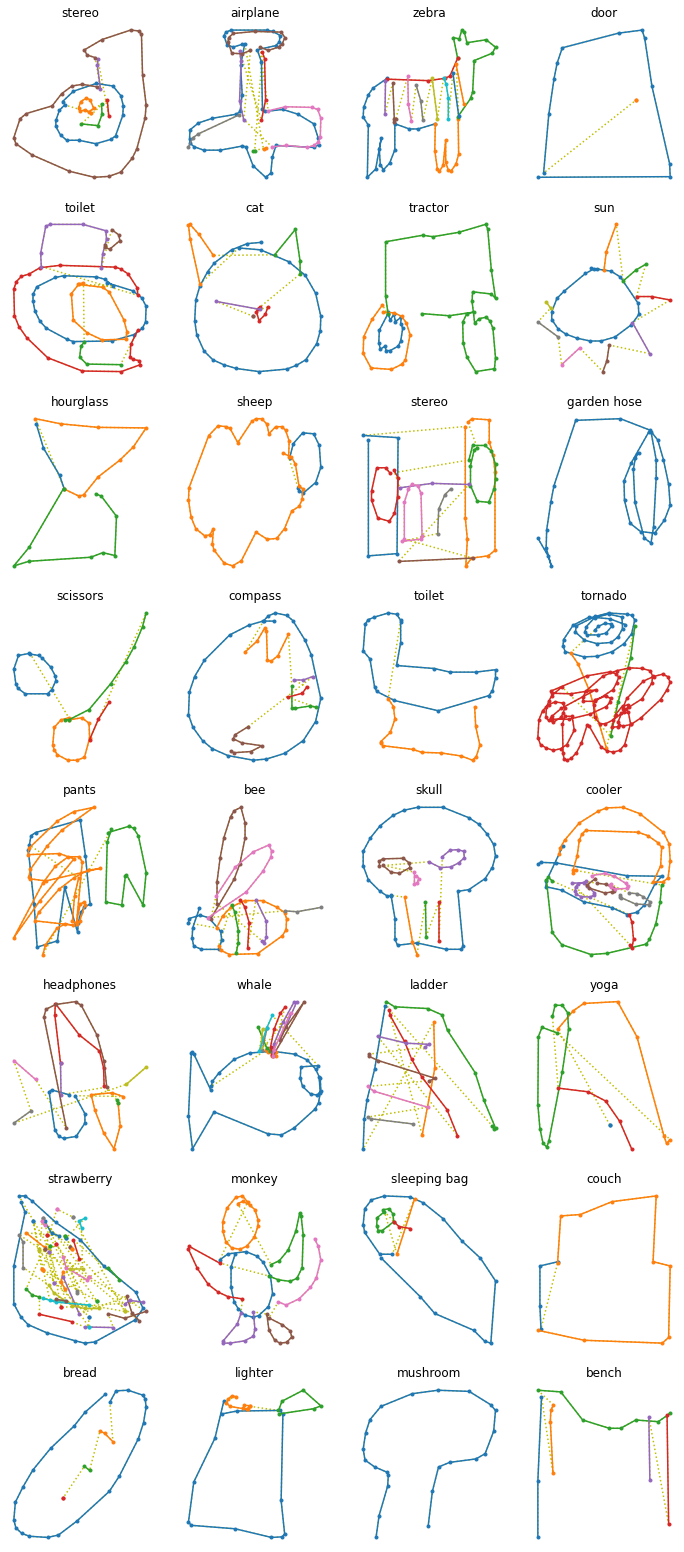

In [19]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:,0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices +1)
    title = class_names[label.numpy()] if label is not None else 'Try to guess'
    plt.title(title)
    plt.plot(coordinates[:,0], -coordinates[:, 1], 'y:')
    for stroke in strokes:
        plt.plot(stroke[:,0], -stroke[:, 1], '.-')
    plt.axis('off')

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

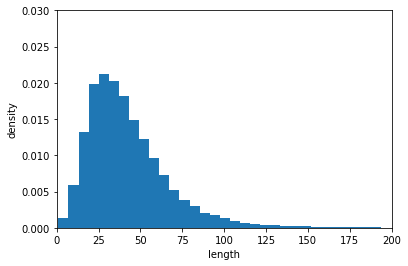

In [20]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins = 150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel('length')
plt.ylabel('density')
plt.show()

In [21]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics =['accuracy', 'sparse_top_k_categorical_accuracy'])
history = model.fit(cropped_train_set, epochs=2, validation_data = cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2106s 19ms/step - loss: 4.8805 - accuracy: 0.0769 - sparse_top_k_categorical_accuracy: 0.1991 - val_loss: 3.1225 - val_accuracy: 0.3012 - val_sparse_top_k_categorical_accuracy: 0.5849
Epoch 2/2
107813/107813 [==============================] - 2049s 19ms/step - loss: 2.8875 - accuracy: 0.3463 - sparse_top_k_categorical_accuracy: 0.6341 - val_loss: 2.5205 - val_accuracy: 0.4125 - val_sparse_top_k_categorical_accuracy: 0.7021


In [23]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [24]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.58777124

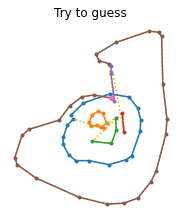

Top-5 predictions
  1. bear 17.410%
  2. pig 11.276%
  3. frog 8.864%
  4. mouse 8.273%
  5. alarm clock 4.084%
Answer: stereo


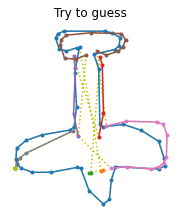

Top-5 predictions
  1. mermaid 18.779%
  2. flamingo 15.779%
  3. duck 6.836%
  4. kangaroo 6.239%
  5. giraffe 5.392%
Answer: airplane


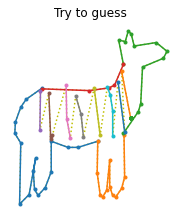

Top-5 predictions
  1. zebra 40.283%
  2. horse 20.824%
  3. tiger 18.591%
  4. cow 5.578%
  5. ant 2.249%
Answer: zebra


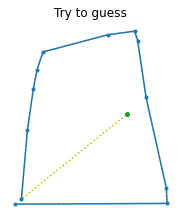

Top-5 predictions
  1. skyscraper 31.774%
  2. finger 14.941%
  3. streetlight 8.990%
  4. hexagon 2.879%
  5. matches 2.622%
Answer: door


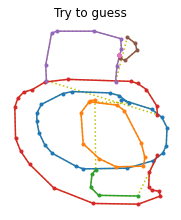

Top-5 predictions
  1. snowman 39.567%
  2. teddy-bear 20.273%
  3. bear 13.659%
  4. alarm clock 4.196%
  5. monkey 2.089%
Answer: toilet


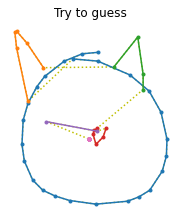

Top-5 predictions
  1. sun 36.885%
  2. mouse 13.604%
  3. blueberry 8.956%
  4. apple 6.454%
  5. alarm clock 6.420%
Answer: cat


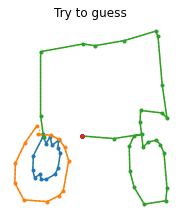

Top-5 predictions
  1. headphones 20.310%
  2. tractor 9.917%
  3. bulldozer 5.408%
  4. car 5.018%
  5. octopus 4.373%
Answer: tractor


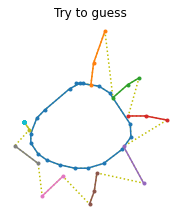

Top-5 predictions
  1. sun 98.286%
  2. spider 1.022%
  3. octopus 0.100%
  4. crab 0.062%
  5. ant 0.060%
Answer: sun


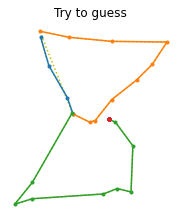

Top-5 predictions
  1. shovel 22.344%
  2. screwdriver 18.575%
  3. lightning 8.877%
  4. floor lamp 8.726%
  5. knee 6.021%
Answer: hourglass


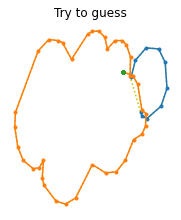

Top-5 predictions
  1. sheep 64.224%
  2. cloud 16.502%
  3. rain 8.060%
  4. bush 2.005%
  5. camel 1.201%
Answer: sheep


In [25]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print('Top-5 predictions'.format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [26]:
model.save("my_sketchrnn")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets
